In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [7]:
%load_ext autoreload
%autoreload 2
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_class_path, MonomersLib, HELMConverter
from node import MolSentenceNode #change after Filter implementation
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_path, model_dir, lang_class_path, lang_path = (conf.get(k) for k in ("model_class_path", "model_dir", "lang_class_path", "lang_path"))
lang_class = get_class_from_class_path(lang_class_path)
lang = lang_class.load(repo_root + lang_path)
if lang_class_path.endswith("HELM"):
    lang.converter = HELMConverter(MonomersLib().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml"))
model_class = get_class_from_class_path(model_class_path)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_path, reward_conf = (conf.get(k) for k in ("reward_class_path", "reward_conf"))
reward_class = get_class_from_class_path(reward_class_path)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_path", "policy_conf"))
policy_class = get_class_from_class_path(policy_class_path)
policy = policy_class(**policy_conf)

Search is started.
0- time: 0.19, count_rollouts: 2, reward: -0.3842155990953244, mol: PEPTIDE1{[ac].L.L.Q.A.R.V.A.R.[am]}$$$$
1- time: 0.37, count_rollouts: 4, reward: -0.3364934903075694, mol: PEPTIDE1{R.P.[dK].[dP].[dQ].[dQ].F.F.G.L.M.[am]}$$$$
2- time: 0.42, count_rollouts: 5, reward: -0.4000672564831415, mol: PEPTIDE1{Y.G.G.F.L.R.R.I.R.[dP].K.L.K.[am]}$$$$
3- time: 0.67, count_rollouts: 7, reward: -0.3780101315653639, mol: PEPTIDE1{F.C.G.G.F.Y.L.R.K.C.I.P.E.L.G.R}$$$$
4- time: 1.03, count_rollouts: 9, reward: -0.2038881347447343, mol: PEPTIDE1{T.A.Y.F.L.L.K.R.P.G.R.W}$$$$
5- time: 1.10, count_rollouts: 10, reward: -0.13186757386178616, mol: PEPTIDE1{K.K.P.V.[am]}$$$$
6- time: 1.13, count_rollouts: 11, reward: -0.03468907578727507, mol: PEPTIDE1{L.Q.L.W.A.W.G.R.V}$$$$
7- time: 1.18, count_rollouts: 12, reward: -0.655418931038301, mol: PEPTIDE1{S.N.C.S.T.I.P.T.G.V}$$$$
8- time: 1.62, count_rollouts: 15, reward: -0.37208932811824746, mol: PEPTIDE1{[dR].Q.I.R.[am]}$$$$
9- time: 1.65, 

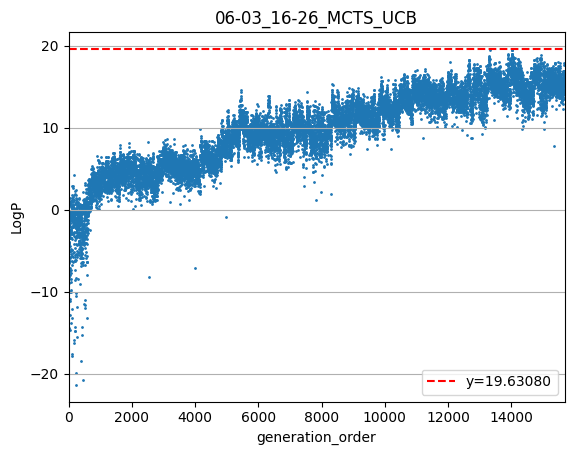

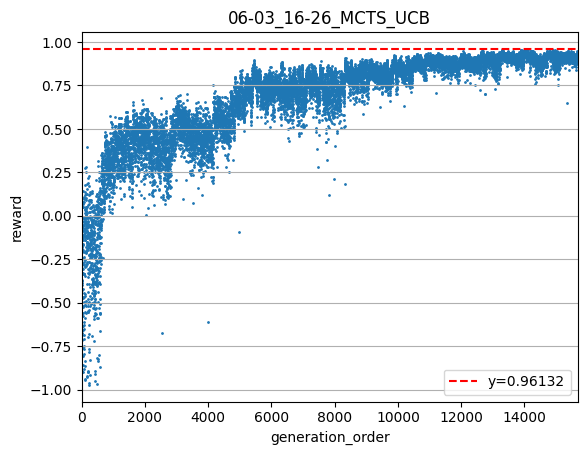

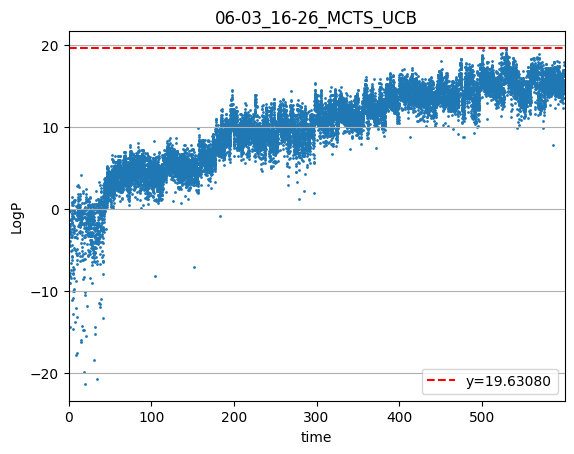

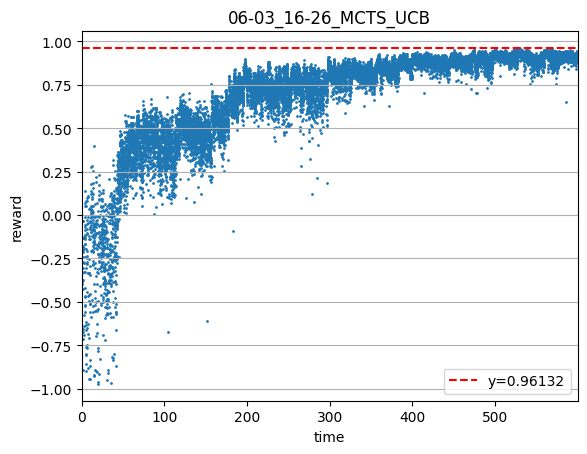

Search is completed.


In [19]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)